In [1]:
import sys
sys.path.append('../../')

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *
import fastai.vision.learner as fvl
from fastai.vision.learner import cnn_config
from fastai.vision.models.unet import DynamicUnet

from skimage import filters
from skimage.util import random_noise
from functools import partial
from model.metrics import *

# Choose GPU Device

In [3]:
torch.cuda.set_device(1)

# Set Experiment Name

In [4]:
nb_name = 'test_sharp_loss'

# Load Data

In [5]:
from data.load import get_data

In [6]:
fastai.__version__

'1.0.59'

### Parameters for Data Loading

In [8]:
bs = 8  # batch size
size = 512  # image size
data_pth = Path('/data/alaa/Dropbox (BPHO)/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/crappified/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_path = data_pth/f'EM/models/'  # path to saved models

In [9]:
# Store dataset in a databunch object 
data = get_data(data_pth, lr_dir, hr_dir, bs, 
                in_sz=size, out_sz=size, max_zoom=3)

/data/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/crappified


# Loss Functions & Evaluation Metrics

In [10]:
from model.metrics import psnr, ssim
metrics = [F.mse_loss, psnr, ssim]

In [11]:
from model.losses import sharp_loss

# Modelling

In [12]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, 
#                      loss_func=feat_loss,
                     loss_func=sharp_loss,
#                      loss_func=F.mse_loss,
                     metrics=metrics, 
                     #callback_fns=LossMetrics, 
                     blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

0

## Load Model (optional)

In [12]:
fvl

<module 'fastai.vision.learner' from '/data/alaa/anaconda3/envs/Salk/lib/python3.7/site-packages/fastai/vision/learner.py'>

In [13]:
expt_num = '1'
learn = learn.load(f'{nb_name}.{expt_num}')
print(f"Experiment: {nb_name} \t Level: {expt_num} | Model Loaded")

## Model Training

## Level: 1

In [16]:
def do_fit(save_name, lrs=1e-3, pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [13]:
# Learning rate finder
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


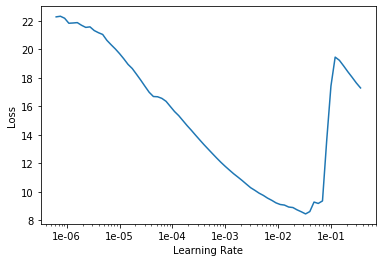

In [14]:
# Visualize LR finder results, choose a lr value
learn.recorder.plot()

In [ ]:
lr = 2e-4  # put LR value here
# start training
do_fit(f'{nb_name}.1', lr, cycle_len=1)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time


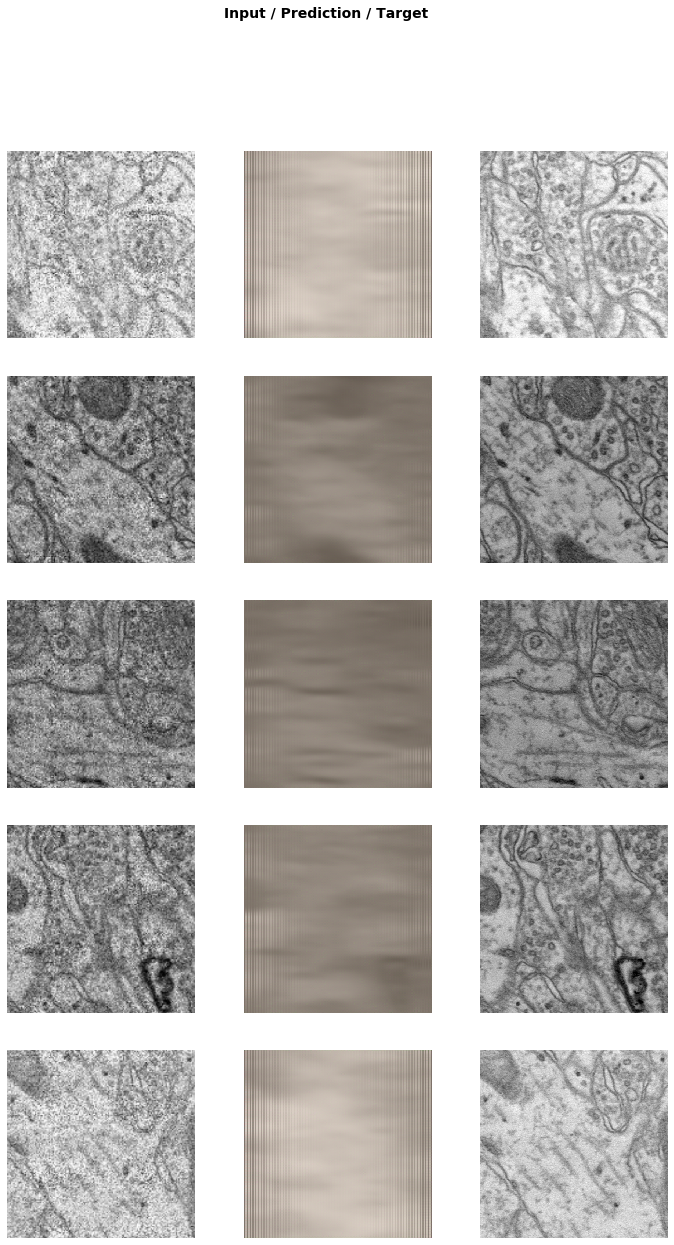

In [17]:
learn.show_results()

## Result: Failed experiment, sharpness term might be too high

## Level: 2

In [13]:
learn.lr_find(start_lr=1e-06, end_lr=0.01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


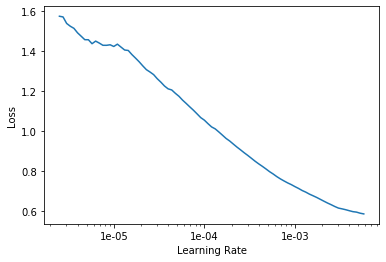

In [14]:
learn.recorder.plot()

In [ ]:
lr = 1e-4  # put LR value here
# start training
do_fit(f'{nb_name}.2', lr, cycle_len=1)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
